In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.applications import InceptionV3, ResNet50, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adamax  # Import Adamax here
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the dataset
def load_data(data_dir):
    filepaths = []
    labels = []
    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
    Fseries = pd.Series(filepaths, name='filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis=1)
    return df


In [3]:
# Change label names to original names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 
             'lung_n': 'Lung_benign_tissue', 
             'lung_scc': 'Lung_squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

# Load and preprocess data
data_dir = './lung_image_sets'
df = load_data(data_dir)
change_label_names(df, 'labels')

# Data splitting: 80% training and 20% validation/test
train_df, ts_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)
valid_df, test_df = train_test_split(ts_df, train_size=0.5, shuffle=True, random_state=42)

# Data generators
batch_size = 32
img_size = (224, 224)
tr_gen = ImageDataGenerator(rescale=1. / 255)
ts_gen = ImageDataGenerator(rescale=1. / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', 
                                       target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle=True, batch_size=batch_size)


Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


In [4]:
# Model Building: Hybrid Model using InceptionV3, ResNet50, and MobileNetV2
input_tensor = Input(shape=(224, 224, 3))

# InceptionV3
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model_inception.layers[:-10]:  # Fine-tuning last 10 layers
    layer.trainable = False
inception_out = GlobalAveragePooling2D()(base_model_inception.output)

# ResNet50
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model_resnet.layers:  # Freeze the base model
    layer.trainable = False
resnet_out = GlobalAveragePooling2D()(base_model_resnet.output)

# MobileNetV2
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in base_model_mobilenet.layers[:-20]:  # Fine-tuning last 20 layers
    layer.trainable = False
mobilenet_out = GlobalAveragePooling2D()(base_model_mobilenet.output)

# Concatenate outputs
com 
# Final layers
x = BatchNormalization()(combined)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)  # 3 classes

# Create model
model = Model(inputs=input_tensor, outputs=output)

# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)



In [5]:
# Train the model
epochs = 5
history = model.fit(train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, shuffle=False,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 704s 2s/step - accuracy: 0.7601 - loss: 0.5752 - val_accuracy: 0.8760 - val_loss: 0.3026 - learning_rate: 1.0000e-04
Epoch 2/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.9266 - loss: 0.2032 - val_accuracy: 0.9280 - val_loss: 0.1975 - learning_rate: 1.0000e-04
Epoch 3/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.9527 - loss: 0.1380 - val_accuracy: 0.9580 - val_loss: 0.1021 - learning_rate: 1.0000e-04
Epoch 4/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.9668 - loss: 0.0965 - val_accuracy: 0.9733 - val_loss: 0.0677 - learning_rate: 1.0000e-04
Epoch 5/5
375/375 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - accuracy: 0.9740 - loss: 0.0746 - val_accuracy: 0.9820 - val_loss: 0.0459 - learning_rate: 1.0000e-04


In [6]:
# Model Performance Plotting
def model_performance(history, epochs):
    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    Epochs = [i+1 for i in range(len(tr_acc))]
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [16]:
# Model Evaluation
def model_evaluation(model, train_gen, valid_gen, test_gen):
    # Evaluate on training data
    train_score = model.evaluate(train_gen, verbose=1)
    # Evaluate on validation data
    valid_score = model.evaluate(valid_gen, verbose=1)
    # Evaluate on test data
    test_score = model.evaluate(test_gen, verbose=1)
   
    # Print evaluation metrics
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

# Data generator for the test set
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', 
                                      target_size=img_size, class_mode='categorical', 
                                      color_mode='rgb', shuffle=False, batch_size=batch_size)

# Evaluate the model
model_evaluation(model, train_gen, valid_gen, test_gen)


Found 1500 validated image filenames belonging to 3 classes.
375/375 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.9921 - loss: 0.0225
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9825 - loss: 0.0547
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9783 - loss: 0.0624
Train Loss:  0.023534271866083145
Train Accuracy:  0.9917500019073486
--------------------
Validation Loss:  0.045941904187202454
Validation Accuracy:  0.9819999933242798
--------------------
Test Loss:  0.05950901284813881
Test Accuracy:  0.9793333411216736


In [13]:
# Get Predictions
def get_pred(model, test_gen):
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    return y_pred

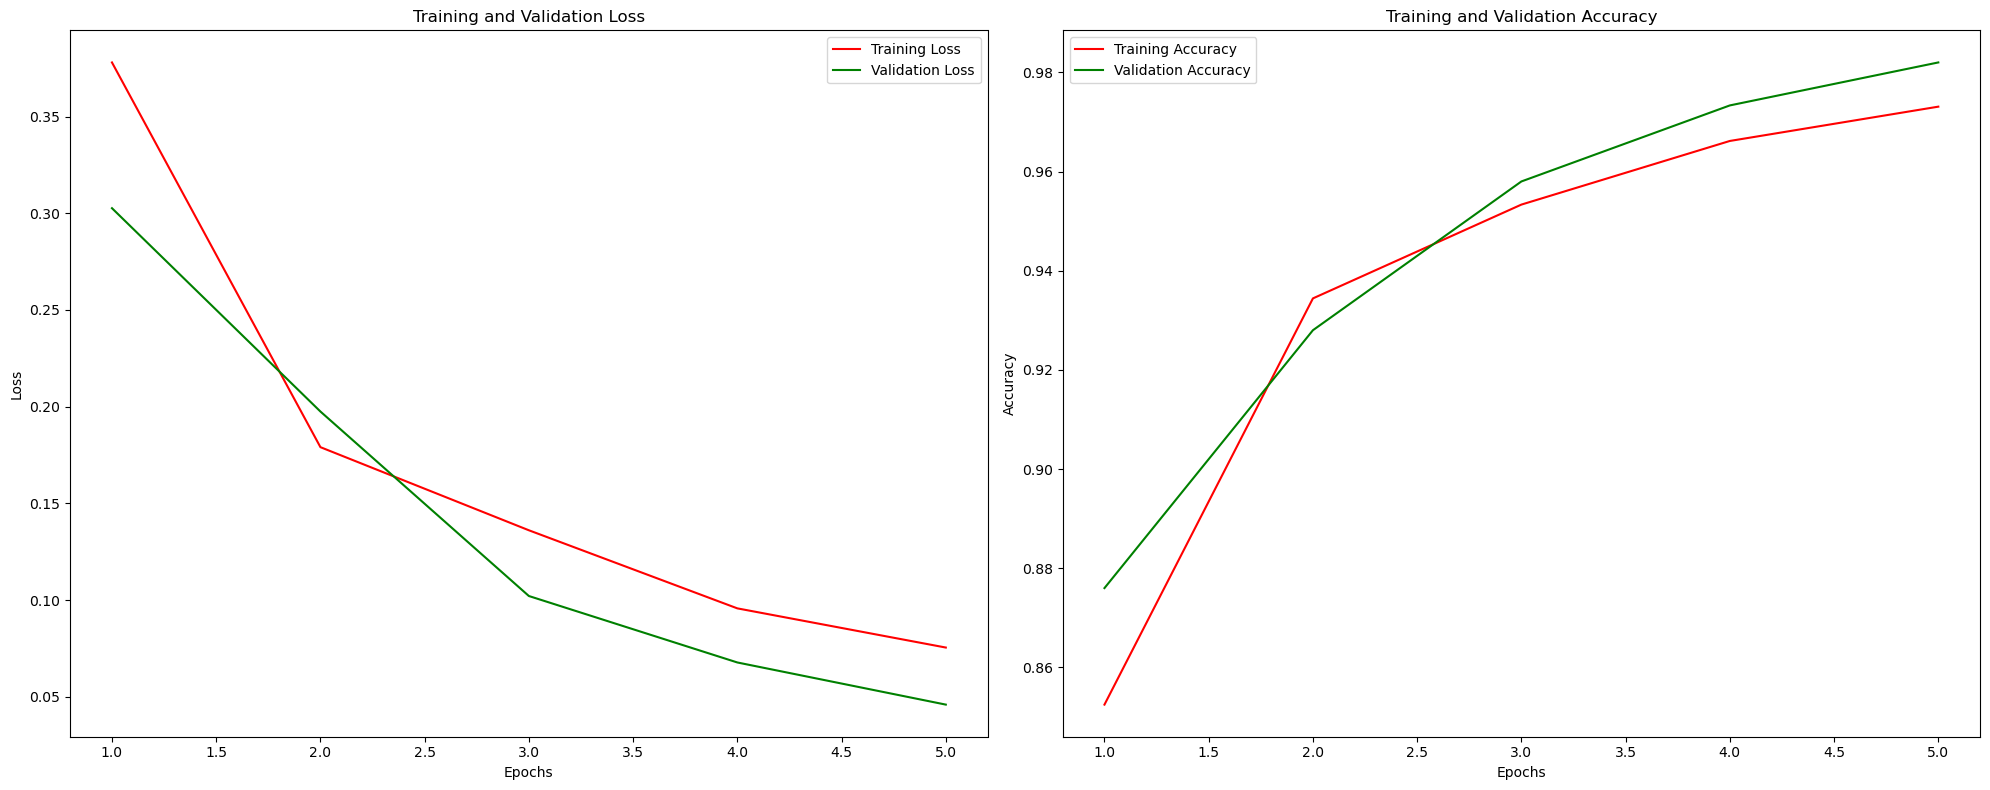

In [10]:
# Call the function with history object and number of epochs
epochs = len(history.history['accuracy'])  # Number of epochs based on history
model_performance(history, epochs)

47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step


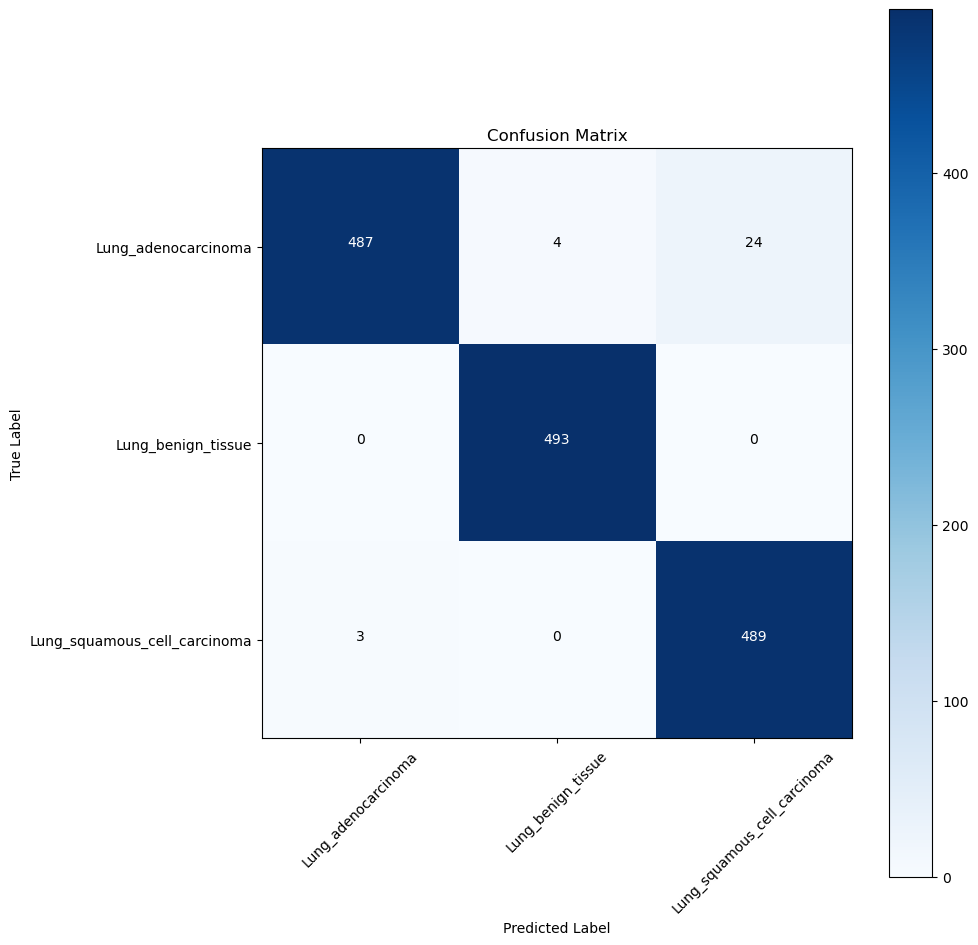

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model

# Confusion Matrix
def plot_confusion_matrix(model, test_gen):
    # Generate predictions
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Get true labels
    true_labels = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Example of usage
plot_confusion_matrix(model, test_gen)